In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import itertools
import scipy
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score
f = open('household_power_consumption.txt')
data = pd.read_csv(f,sep=';', header='infer',parse_dates=[['Date', 'Time']],infer_datetime_format=True)
data = data.dropna(axis=0, thresh=3)
df = pd.DataFrame(index = pd.to_datetime(data['Date_Time']),
                        data = data['Global_active_power'].values, columns=['Active_Power'])
#df = df[:5000]
df[['Active_Power']] = df[['Active_Power']].apply(pd.to_numeric,errors='coerce')

def cleanData(df):
    #hard thresholding
    # any condition that introduces some kind of threshold is fine
    # in this case we prohibit values smaller than 1.5 stds
    threshold = np.mean(df['Active_Power']) - 1.5*np.std(df['Active_Power'])
    df['Active_Power'][df['Active_Power'] < threshold] = np.nan
    return df.interpolate(method='linear')
df = cleanData(df)



C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [303]:
def group_by_hours(df):
    temp_list = []
    for i in range(0,24):
        hourly_data = np.mean(df[df.index.hour == i]['Active_Power'])
        temp_list.append(hourly_data)
    df = pd.DataFrame(data=temp_list)
    return df

def draw_quarter(df):
    for i in range(1,5):
        xdata = df[df.index.quarter == i].index.hour
        ydata = df[df.index.quarter == i]
        plt.figure()
        plt.plot(xdata,ydata,color='k', alpha=0.3, linewidth='2')
        temp = group_by_hours(ydata)
        plt.plot(temp,alpha = 1, linewidth = '5')
        
def draw_quarterbox(df):
    for i in range(1,5):
        temp_list = []
        ydata = df[df.index.quarter == i]
        for j in range(0,24):
            hourly_data = ydata[ydata.index.hour == j]['Active_Power'].values
            temp_list.append(hourly_data)
        plt.figure()
        plt.boxplot(temp_list)

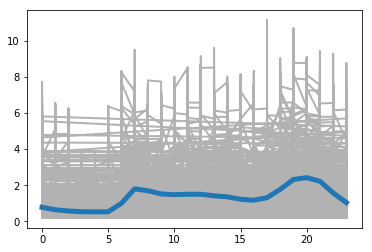

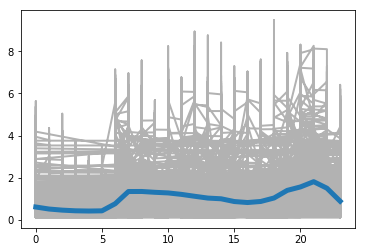

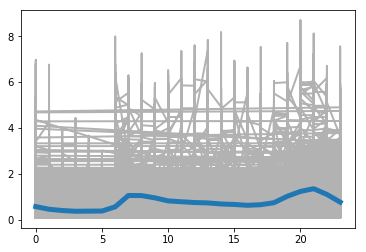

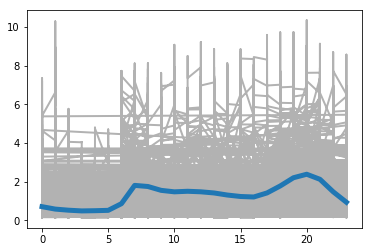

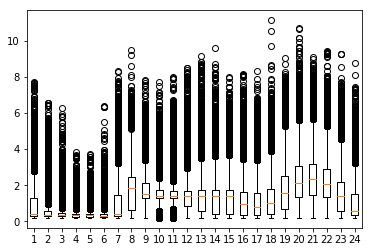

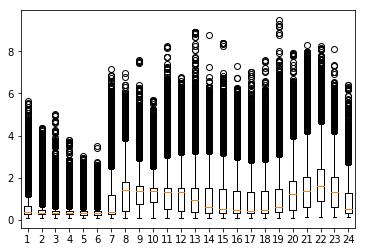

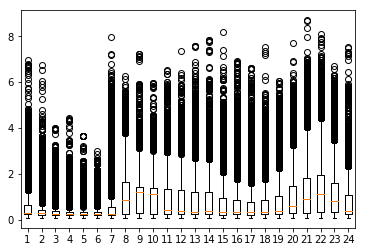

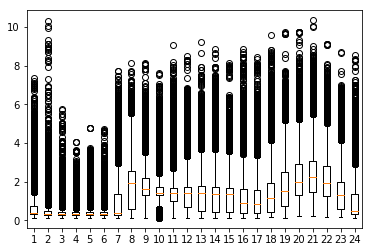

In [304]:
draw_quarter(df)
draw_quarterbox(df)

In [305]:
# create load curves
df.head()

,Active_Power
Date_Time,
2006-12-16 17:24:00,4.216
2006-12-16 17:25:00,5.360
2006-12-16 17:26:00,5.374
2006-12-16 17:27:00,5.388
2006-12-16 17:28:00,3.666


In [3]:
df['Hour'] = df.index.hour
df['DayofYear'] = df.index.dayofyear
df['Weekday'] = df.index.dayofweek

In [4]:
loadCurves = (df.groupby(['DayofYear', 'Hour'])['Active_Power'].mean()).unstack()

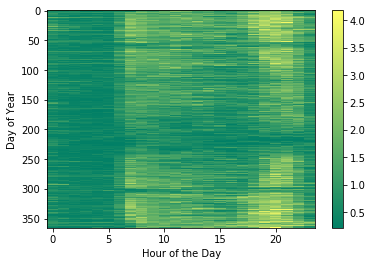

In [5]:
import matplotlib.colors as clrs
plt.imshow(loadCurves, aspect='auto',cmap='summer')
plt.ylabel('Day of Year')
plt.xlabel('Hour of the Day')
plt.colorbar()

In [6]:
Load_Weekday = df.groupby(['Weekday']).mean()

In [7]:
Load_Weekday

,Active_Power,Hour,DayofYear
Weekday,,,
0,1.001749,11.500000,181.325243
1,1.074770,11.500000,180.553398
2,1.085026,11.500000,181.553398
3,0.982072,11.500000,180.776699
4,1.042086,11.493721,179.915301
5,1.233651,11.511631,180.500548
6,1.213079,11.500000,182.097087


([<matplotlib.axis.XTick at 0x27bee7fc748>,
 <a list of 7 Text xticklabel objects>)

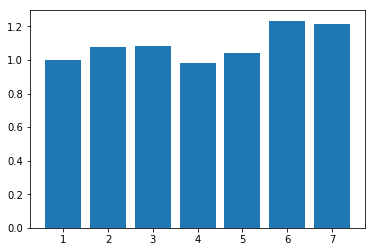

In [8]:
plt.bar(Load_Weekday.index,Load_Weekday['Active_Power'])
plt.xticks(Load_Weekday.index, [1,2,3,4,5,6,7])

In [312]:
# read temperature data
f = open('T_data.csv')
data = pd.read_csv(f,sep=';', header='infer',parse_dates=[['Year', 'Month','Day'],['Hour','Minute']],infer_datetime_format=True)
data['Hour_Minute']=data['Hour_Minute'].str.replace(' ', ':')
data['Time']=(data['Year_Month_Day'].astype(str) + ' ' + data['Hour_Minute'].astype(str))
t_df = pd.DataFrame(index = pd.to_datetime(data['Time']),data = data['Temperature'].values, columns=['T'])
f = open('Holiday.csv')
df_holiday = pd.read_csv(f,sep='\t', header='infer',parse_dates=['Date'],infer_datetime_format=True)
df_holiday = pd.DataFrame(index = pd.to_datetime(df_holiday['Date']),
                        data = df_holiday['Boolean'].values, columns=['B'])

In [313]:
df_hourly = df.truncate('2006-12-16 18:00:00','2010-11-26 21:00:00')
df_hourly = df.resample('H').sum()/60
df_hourly['Hour'] = df_hourly.index.hour
df_hourly['DayofYear'] = df_hourly.index.dayofyear
df_hourly['Weekday'] = df_hourly.index.dayofweek
df_hourly['Day'] = df_hourly.index.day
#t_df = t_df.resample('T').mean()
t_df = t_df.astype(float)
#t_df = t_df.interpolate(method='linear', axis=0).ffill().bfill()

t_df = t_df.truncate('2006-12-16 18:00:00','2010-11-26 21:00:00')
df_final = pd.concat([df_hourly,t_df],axis=1)
df_final.dropna(inplace=True)

In [314]:
df_final['check_holiday'] = np.where(df_final['Weekday']<5, 0, 1)
df_final['check_holiday'] = np.where(df_final['Day'].isin(df_holiday.index), 1, 0)
df_final['check_work_hour'] = np.where(df_final['Hour'].isin(range(9,18)), 1, 0)
df_final['check_work_hour'] = np.where(df_final['check_holiday'] == 1, 0, 1)
df_final['check_sleep_hour'] = np.where(df_final['Hour'].isin([23,0,1,2,3,4,5,6]), 1, 0)

In [315]:
import statsmodels.api as sm
X = df_final[["T","Hour",'check_work_hour','check_sleep_hour']][:1000000] ## X usually means our input variables (or independent variables)
y = df_final["Active_Power"][:1000000] ## Y usually means our output/dependent variable
X = sm.add_constant(X) ## let's add an intercept (beta_0) to our model

# Note the difference in argument order
model = sm.OLS(y, X).fit() ## sm.OLS(output, input)
predictions = model.predict(X)

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Active_Power   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     5365.
Date:                Sat, 16 Dec 2017   Prob (F-statistic):               0.00
Time:                        17:33:30   Log-Likelihood:                -40536.
No. Observations:               34588   AIC:                         8.108e+04
Df Residuals:                   34585   BIC:                         8.110e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
T                   -0.0198      0.000    -61.352      0.000      -0.020      -0.019
check_work_hour      2.4321      0.019    131.045      0.000       2.396       2.469
check_sleep_hour    -0.8832      0.009    -96.037      0.000      -0.901      -0.865
==============================================================================
Omnibus:                     6882.340   Durbin-Watson:                   0.706
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15404.423
Skew:                           1.144   Prob(JB):                         0.00
Kurtosis:                       5.335   Cond. No.                         247.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

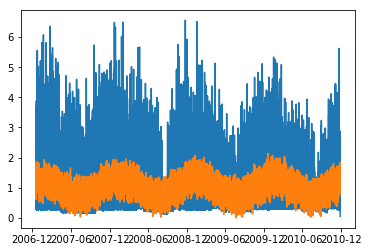

In [316]:

plt.plot(df_final['Active_Power'][:200000])
plt.plot(predictions[:200000])

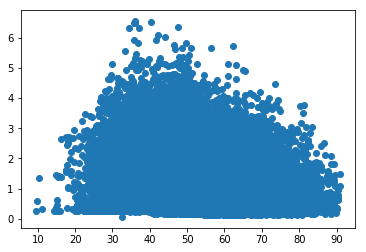

In [317]:
plt.scatter(df_final['T'][:100000],df_final['Active_Power'][:100000])